In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from collections import Counter
import re
import os

In [5]:
files_path = "./data/simpsons/"

characters_df = pd.read_csv(os.path.join(files_path, 'simpsons_characters.csv'))
episodes_df = pd.read_csv(os.path.join(files_path, 'simpsons_episodes.csv'))
locations_df = pd.read_csv(os.path.join(files_path, 'simpsons_locations.csv'))
script_lines_df = pd.read_csv(
    os.path.join(files_path, 'simpsons_script_lines.csv'),
    quotechar='"',
    dtype={
        "speaking_line": "string", 
        "character_id": "string", 
    },
    na_values=["", "NaN"],
    low_memory=False
)

# speaking_line to boolean
script_lines_df["speaking_line"] = script_lines_df["speaking_line"].map({"TRUE": True, "FALSE": False})

# character_id to int64 with support for NaN
script_lines_df["character_id"] = pd.to_numeric(script_lines_df["character_id"], errors="coerce").astype("Int64")


In [6]:
episodes_df.head(3)

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views
0,10,http://static-media.fxx.com/img/FX_Networks_-_...,7.4,1511.0,10,10,1990-03-25,1990,7G10,1,Homer's Night Out,30.3,http://www.simpsonsworld.com/video/275197507879,50816.0
1,12,http://static-media.fxx.com/img/FX_Networks_-_...,8.3,1716.0,12,12,1990-04-29,1990,7G12,1,Krusty Gets Busted,30.4,http://www.simpsonsworld.com/video/288019523914,62561.0
2,14,http://static-media.fxx.com/img/FX_Networks_-_...,8.2,1638.0,1,14,1990-10-11,1990,7F03,2,"Bart Gets an ""F""",33.6,http://www.simpsonsworld.com/video/260539459671,59575.0


In [7]:
script_lines_df.head(3)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,NaN,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,NaN,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,NaN,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22


In [8]:
characters_df.head(3)

,id,name,normalized_name,gender
0,7,Children,children,NaN
1,12,Mechanical Santa,mechanical santa,NaN
2,13,Tattoo Man,tattoo man,NaN


In [9]:
locations_df.head(3)

,id,name,normalized_name
0,1,Street,street
1,2,Car,car
2,3,Springfield Elementary School,springfield elementary school


In [10]:
print("\nDATASET SUMMARY")
print("=" * 50)
print(f"Episodes: {len(episodes_df):,}")
print(f"Characters: {len(characters_df):,}")
print(f"Locations: {len(locations_df):,}")
print(f"Script lines: {len(script_lines_df):,}")

# stats per season
season_stats = episodes_df.groupby('season').agg({
    'title': 'count',
    'imdb_rating': 'mean',
    'us_viewers_in_millions': 'mean'
}).round(2)

print(f"\nAvailable seasons: {episodes_df['season'].min()} - {episodes_df['season'].max()}")


DATASET SUMMARY
Episodes: 600
Characters: 6,722
Locations: 4,459
Script lines: 158,271

Available seasons: 1 - 28


In [11]:
# Best & Worst Rated Episodes
best_episodes = episodes_df.sort_values(by='imdb_rating', ascending=False).head(3)
worst_episodes = episodes_df.sort_values(by='imdb_rating').head(3)

# Lines per episode
lines_per_episode = script_lines_df.groupby('episode_id')['raw_text'].count().reset_index()
lines_per_episode = lines_per_episode.merge(episodes_df[['id', 'title']], left_on='episode_id', right_on='id')
most_lines = lines_per_episode.sort_values(by='raw_text', ascending=False).head(3)
least_lines = lines_per_episode.sort_values(by='raw_text').head(3)

# Top characters
top_chars = script_lines_df['character_id'].value_counts().head(10)
top_chars_df = pd.DataFrame({
    'character_id': top_chars.index.astype(int),
    'num_lines': top_chars.values
}).merge(characters_df, left_on='character_id', right_on='id')
top_chars_df = top_chars_df.sort_values(by='num_lines', ascending=False)

# Top locations
loc_lines = script_lines_df['location_id'].value_counts().head(10)
loc_names = [locations_df[locations_df['id'] == loc_id]['name'].iloc[0]
             if loc_id in locations_df['id'].values else f"ID: {loc_id}" for loc_id in loc_lines.index]

# Homero: lines per episode
homer_id = characters_df[characters_df['name'] == 'Homer Simpson']['id'].iloc[0]
homer_lines = script_lines_df[script_lines_df['character_id'] == homer_id]
homer_lines_per_episode = homer_lines.groupby('episode_id')['raw_text'].count().reset_index()
homer_lines_per_episode = homer_lines_per_episode.merge(episodes_df[['id', 'title', 'season']], left_on='episode_id', right_on='id')
most_homer = homer_lines_per_episode.sort_values(by='raw_text', ascending=False).head(1)
least_homer = homer_lines_per_episode.sort_values(by='raw_text').head(1)

# Top and bottom by viewers
most_viewed = episodes_df.sort_values(by='us_viewers_in_millions', ascending=False).head(3)
least_viewed = episodes_df.sort_values(by='us_viewers_in_millions').head(3)

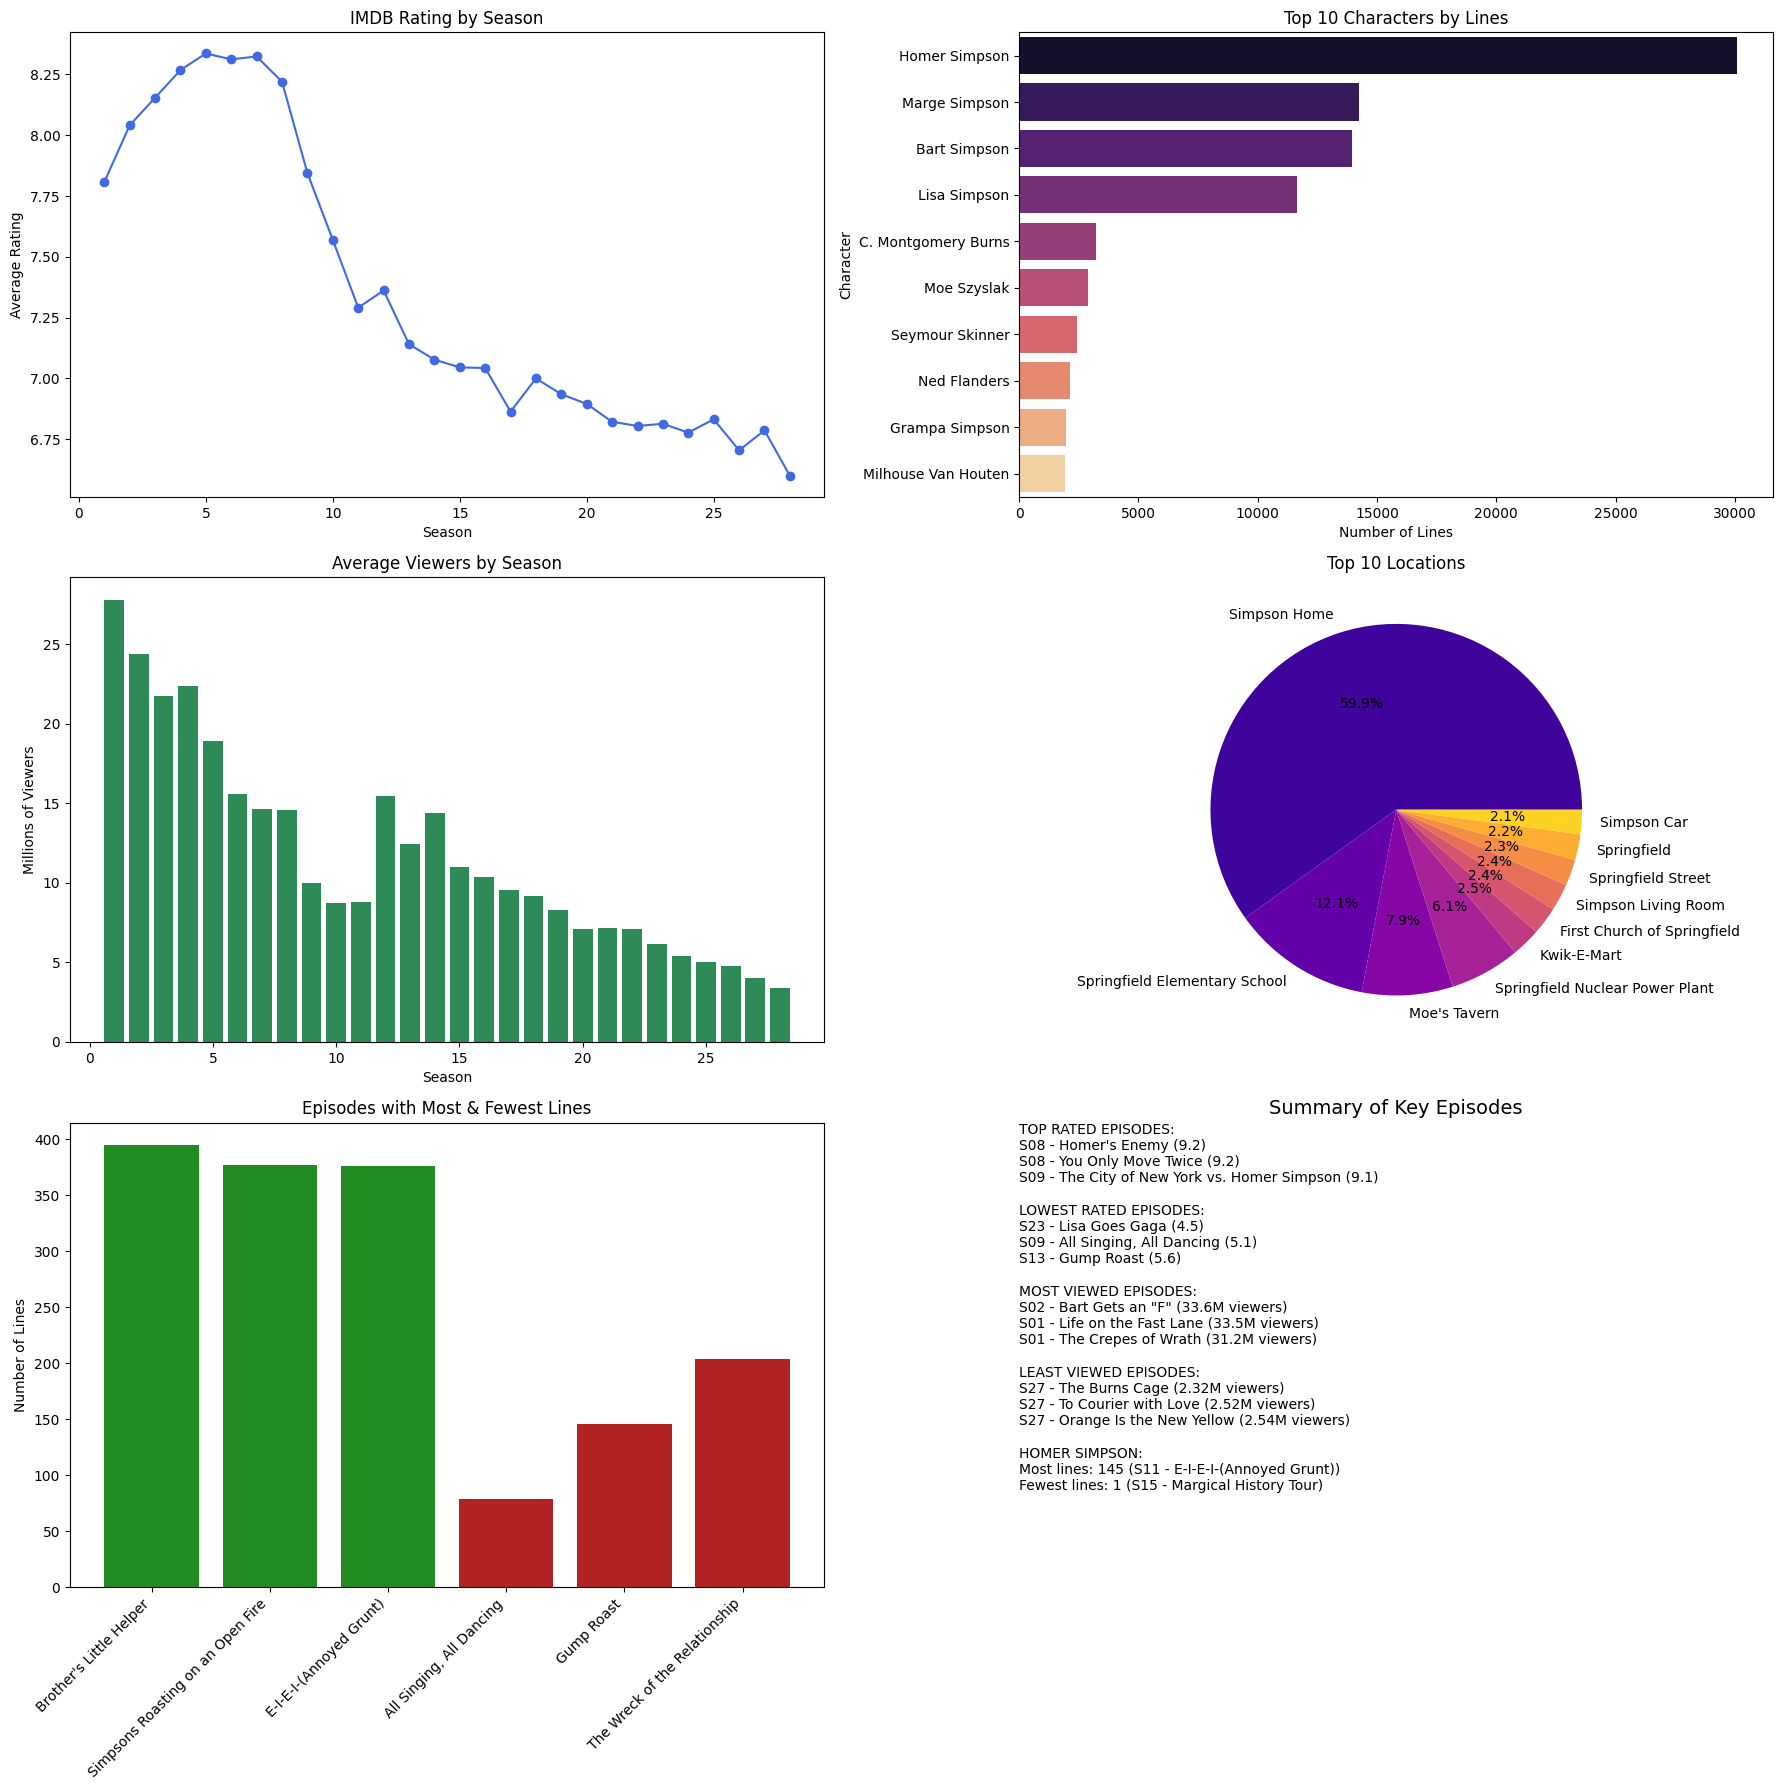

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Subplot 1: Ratings by season
season_ratings = episodes_df.groupby('season')['imdb_rating'].mean()
axes[0, 0].plot(season_ratings.index, season_ratings.values, marker='o', color='royalblue')
axes[0, 0].set_title('IMDB Rating by Season')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Average Rating')

# Subplot 2: Top characters
sns.barplot(
    ax=axes[0, 1],
    data=top_chars_df,
    y='name',
    x='num_lines',
    hue='name',
    palette='magma',
    legend=False,
    errorbar=None
)
axes[0, 1].set_title('Top 10 Characters by Lines')
axes[0, 1].set_xlabel('Number of Lines')
axes[0, 1].set_ylabel('Character')

# Subplot 3: Viewers by season
season_viewers = episodes_df.groupby('season')['us_viewers_in_millions'].mean()
axes[1, 0].bar(season_viewers.index, season_viewers.values, color='seagreen')
axes[1, 0].set_title('Average Viewers by Season')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Millions of Viewers')

# Subplot 4: Top locations
axes[1, 1].pie(
    loc_lines.values,
    labels=loc_names,
    autopct='%1.1f%%',
    colors=sns.color_palette("plasma", len(loc_lines))
)
axes[1, 1].set_title('Top 10 Locations')

# Subplot 5: Outliers by lines
titles = list(most_lines['title']) + list(least_lines['title'])
values = list(most_lines['raw_text']) + list(least_lines['raw_text'])
colors_bars = ['forestgreen'] * 3 + ['firebrick'] * 3

axes[2, 0].bar(titles, values, color=colors_bars)
axes[2, 0].set_title('Episodes with Most & Fewest Lines')
axes[2, 0].set_ylabel('Number of Lines')
axes[2, 0].set_xticks(range(len(titles)))
axes[2, 0].set_xticklabels(titles, rotation=45, ha='right')

# Subplot 6: Summary
text = "TOP RATED EPISODES:\n"
for _, row in best_episodes.iterrows():
    text += f"S{row['season']:02d} - {row['title']} ({row['imdb_rating']})\n"

text += "\nLOWEST RATED EPISODES:\n"
for _, row in worst_episodes.iterrows():
    text += f"S{row['season']:02d} - {row['title']} ({row['imdb_rating']})\n"

text += "\nMOST VIEWED EPISODES:\n"
for _, row in most_viewed.iterrows():
    text += f"S{row['season']:02d} - {row['title']} ({row['us_viewers_in_millions']}M viewers)\n"

text += "\nLEAST VIEWED EPISODES:\n"
for _, row in least_viewed.iterrows():
    text += f"S{row['season']:02d} - {row['title']} ({row['us_viewers_in_millions']}M viewers)\n"

text += "\nHOMER SIMPSON:\n"
row_most = most_homer.iloc[0]
text += f"Most lines: {row_most['raw_text']} (S{row_most['season']:02d} - {row_most['title']})\n"
row_least = least_homer.iloc[0]
text += f"Fewest lines: {row_least['raw_text']} (S{row_least['season']:02d} - {row_least['title']})"

axes[2, 1].axis('off')
axes[2, 1].text(0, 1, text, fontsize=10, verticalalignment='top', horizontalalignment='left')
axes[2, 1].set_title('Summary of Key Episodes', fontsize=14)

plt.tight_layout()
plt.show()